# Basic preparations

In this Notebook, the geospatial fabric for the "Nelson Churchill River Basin" gauge is extracted from the `MERIT-Basins` dataset.

If you are using Graham HPC, and have access to Clark's Research Group allocation (`rrg-mclark`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rrg-mclark/data/geospatial-data/MERIT-Basins/`

If you are using Graham HPC, and have access to Global Water Futures Observatories allocation (`rpp-kshook`), you may find `MERIT-Basins` layers under the following path:</br>
`/project/rpp-kshook/Climate_Forcing_Data/geospatial-data/MERIT-Basins`

The version used is `MERIT_Hydro_v07_Basins_v01_bugfix1` which is a directory under the root directory of the dataset.

Let's get started with our workflow and import necessary Python libraries:

In [ ]:
!yes | pip uninstall hydrant -y

In [ ]:
!pip install git+https://github.com/kasra-keshavarz/hydrant.git

In [ ]:
#import hydrant
#print(hydrant.__version__)

In [ ]:
import geopandas as gpd # version 0.14.0
import pandas as pd # version 1.4.0
import numpy as np # version 1.22.2
import matplotlib.pyplot as plt # version 3.5.1
from shapely.geometry import Point # version 2.0.1
import hydrant.topology.geom as gm # version 0.1.0-dev1
import subprocess # built-in Python 3.10.2
import os # built-in Python 3.10.2
import glob # built-in Python 3.10.2

`Hydrant` is important in this Notebook. We are only using the `topology.geom`etry module.

Path definitions (system dependant - modify accordingly):

In [ ]:
# geofabric paths
merit_basins_root_path = '/project/6008034/Climate_Forcing_Data/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1'
merit_basins_geom_path = os.path.join(merit_basins_root_path, 'pfaf_level_02')
merit_basins_nca_path = os.path.join(merit_basins_root_path, 'coastal_hillslopes')
# output paths
output_path = '/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/'
#bs_path = '/scratch/fuaday/ncrb-models/NCRB_shapefiles/NCRB_SubbasinsDissolved.shp'
nctr_test = '/scratch/fuaday/ncrb-models/NCRB_shapefiles/non.shp' #ncontr_test.shp
nctr_testout = '/scratch/fuaday/ncrb-models/NCRB_shapefiles/ncontr_test.shp' 

In [ ]:
#ncrb = pd.concat([gpd.read_file(f).to_crs(epsg=4326) for f in glob.glob(bs_path)])

In [ ]:
files = glob.glob(nctr_test)

# Load files, set CRS, and concatenate
gdfs = []
for f in files:
    gdf = gpd.read_file(f)
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    gdfs.append(gdf.to_crs(epsg=4326))
ncrb_nca = pd.concat(gdfs)

# Reading `MERIT-Basins` Geospatial Fabric Dataset

Upon **visual** inspection (you may use `QGIS` or similar programs), layer #71 has been identified to include necessary sub-basins for ncrb

As you may see in the cell below, we are using Python `list`s to enable reading multiple layers at once. There are cases where a basin of interest is shared between multiple `pfaf` layers.

For now, let's read the files, one by one:

In [ ]:
# file names
# catchments (subbasin)
cat_files = [
    'cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# rivers (river segments)
riv_files = [
    'riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# non-contributing catchments (those without any river segments defined for them)
nca_files = [
    'hillslope_71_clean.shp',
]

# reading in data in an iterative manner
cat = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in riv_files])
nca = pd.concat([gpd.read_file(os.path.join(merit_basins_nca_path, f)) for f in nca_files])

Since `MERIT-Basins` layers do not come with correct Coordinate Reference System (CRS) information, we need to specify this manually. The `EPSG` code for the `MERIT-Basins` layer is `4326`. Please refer to the following for more information: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset

In [ ]:
# specifying epsg:4326 for all the MERIT-Basins layers
cat.set_crs(epsg=4326, inplace=True)
nca.set_crs(epsg=4326, inplace=True)
riv.set_crs(epsg=4326, inplace=True)

# # Show the EPSG of all geospatial layers
# print(f'`cat` CRS: {cat.crs}')
# print(f'`riv` CRS: {riv.crs}')
# print(f'`nca` CRS: {nca.crs}')

In [ ]:
# # Printing the sizes
# print("Size of catchments (cat):", cat.shape)
# print("Size of rivers (riv):", riv.shape)
# print("Size of non-contributing areas (nca):", nca.shape)

In [ ]:
# # Display the headers of each DataFrame
# print("Header for Catchments (cat):")
# print(cat.head())

# print("\nHeader for Rivers (riv):")
# print(riv.head())

# print("\nHeader for Non-Contributing Areas (nca):")
# print(nca.head())

# Preparing `cat`, `riv`, and `nca` objects for `NCRB`

## Preparing `MERIT-Basins` Layers

Before subsetting the entire layer #71 of the `MERIT-Basins` dataset, we have to assure the layers are ready to be further processed by the `Hydrant` package. Fortunately, `Hydrant` provides necessary functionalities to work with this specific geospatial fabric (applicable to any geospatial fabric in reality). 

In doing so, Hydrant's `geom` module provides the `prepare_cat(...)` function to prepare the `MERIT-Basins` geosptial fabric's sub-basins (or catchments) for the next post-processing steps. Please note that since the non-contributing areas (`nca`) are technically considered sub-basins, they are taken care of using this functionality of `Hydrant`:

In [ ]:
# Hydrant's `geom` module provides the `prepare_cat`
# function to prepare the `MERIT-Basins` geosptial
# fabric for next post-processing steps

catchments = gm.prepare_cat(
    cat=cat, # 
    cat_col_id='COMID'
)

# catchments = gm.prepare_cat(
#     cat=cat, # 
#     cat_col_id='COMID',
#     cst=nca,
#     cst_col_mapper={'FID':'COMID'},
#     cst_col_id='COMID'
# )
# You may see the "docstring" of the `gm.prepare_cat`
# function by running:
# >>> gm.prepare_cat?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_cat.__doc__)

In [ ]:
# catchments = gm.prepare_cat(
#     cat=cat, # 
#     cat_col_id='COMID',
#     cst=nca,
#     cst_col_mapper={'FID':'COMID'},
#     cst_col_id='COMID'
# )

In [ ]:
# added from smm example

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass
catchments.to_file(os.path.join(output_path, 'SourisAsinboine_catchmentsTest.shp'))

Similarly, the `geom` module provides the `prepare_riv(...)` function to prepare the `MERIT-Basins` geospatial fabric's river segments for the next post-processing steps:

In [ ]:
# Similarly, the `geom` module provides the
# `prepare_riv` function to prepare the `MERIT-Basins`
# geospatial fabric's river segments for the next
# post-processing steps:

rivers = gm.prepare_riv(
    riv=riv,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID',
        'slope':'slope',
        'length':'lengthkm',
        'length_direct':'lengthdir'
    },
    cat=catchments,
    cat_cols={
        'id':'COMID',
        'hillslope':'hillslope',
        'geom':'geometry'
    }
)


# You may see the "docstring" of the `gm.prepare_riv`
# function by running:
# >>> gm.prepare_riv?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_riv.__doc__)

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass
rivers.to_file(os.path.join(output_path, 'SourisAsinboine_RiverTest.shp'))

In Python, you may always access the "docstring" documentations for the functions and classes by running:
```python
>>> print(func.__doc__)
```
Or, if you are working in the Jupyter environment, you may simply run the following in a separate Jupyter cell:
```ipython
[ln1] func?
```
If you are interested in reading up on the functionality of each function used above, use the mentioned methods to print the "docstrings".

Therefore, if you would like to read up on the `gm.prepare_cat(...)` or `gm.prepare_riv(...)` functionality, simply uncomment and execute the following cell:

In [ ]:
#gm.prepare_cat?

In [ ]:
# latitude and longitude values for the
# `Great Lakes River Basin at Quebec City` Hydrometric gauge
latitude = 49.88
longitude = -97.155

# create a Point object
point = Point(longitude, latitude)

# show the `point`
point


In [ ]:
print(point)
catchments[catchments.intersects(point)]

In [ ]:
# `glrb` stands for `Great Lakes River Basin at Quebec City `:
sras_catchments, sras_rivers = gm.intersect_topology(
    cat=catchments,
    cat_cols={
        'id':'COMID'
    },
    riv=rivers,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID'
    },
    outlet_id=[71039300,71029567,71028920,71027667,71029525,71029760,71029235,71027231,71029705])

Now, let's plot what have extracted from the larger `MERIT-Basins` geospatial fabric:

In [ ]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20, 12)
)

# Assuming 'ncrb_catchments' and 'ncrb_rivers' are GeoDataFrames and 'point' is a geometry point for the gauge location

# sub-basins
sras_catchments.plot(ax=ax, color='gray', edgecolor='black', alpha=0.8, linewidth=0.3, zorder=1)  # Adjust `linewidth` as needed
# river segments
sras_rivers.plot(ax=ax, color='blue', alpha=1, linewidth=0.3, zorder=2)  # Adjust `linewidth` as needed for rivers

# gauge location
# Assuming 'point' is defined somewhere above as a geometry point
# ax.scatter(point.x, point.y, color='red', alpha=0.8, s=100, zorder=3)  # Use `s` for size in scatter plot, adjust as needed

plt.show()


# Saving Extracted Geospatial Fabric upstream of Bow River at Banff Hydrometric Station

In [ ]:
# saving the results into the `output_path` directory

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass

# then, saving the data
sras_catchments.to_file(os.path.join(output_path, 'sras_subbasins_MAF_noAgg.shp'))
sras_rivers.to_file(os.path.join(output_path, 'sras_rivers_MAF_noAgg.shp'))

In [ ]:
import subprocess
import pandas as pd
import os

# Define paths and parameters
input_basin_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_subbasins_MAF_noAgg.shp"
input_river_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_rivers_MAF_noAgg.shp"
min_subarea = 50   #50, 100, 150
min_slope = 0.0000001
min_length = 1.0
output_basin_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_subbasins_MAF_Agg.shp"
output_river_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_rivers_MAF_Agg.shp"

# Full path to Rscript executable

#rscript_path = "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/r/4.3.1/bin/Rscript"
rscript_path = "/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/r/4.3.1/bin/Rscript"

# Run the R script with arguments
result = subprocess.run([
    rscript_path,
    "basin_aggregation.R",
    input_basin_path,
    input_river_path,
    str(min_subarea),
    str(min_slope),
    str(min_length),
    output_basin_path,
    output_river_path
], capture_output=True, text=True)

# Check if the script executed successfully
if result.returncode != 0:
    print("Error in R script execution")
    print(result.stderr)
else:
    print("R script executed successfully")
    # You can load and process the RDS files if needed
    # output_basin = pd.read_rds(output_basin_path)  # You might need an appropriate RDS reader in Python
    # output_river = pd.read_rds(output_river_path)  # Similarly for the river data

In [1]:
from MESHpyPreProcessing.gdf_edit import flag_ncaalg_from_files

In [10]:
input_basin_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_subbasins_MAF_Agg.shp"
nctr_test = '/scratch/fuaday/ncrb-models/NCRB_shapefiles/non.shp'
#output_river_path = "/home/fuaday/github-repos/Souris_Assiniboine_MAF/1-geofabric/SrsAboine-geofabric/sras_subbasins_MAF_Agg2.shp"
output_river_path = "/home/fuaday/scratch/sras-agg-model/geofabric-outputs/sras_subbasins_MAF_Agg2.shp"

        COMID    unitarea  NextDownID      uparea  \
0  71021939.0   76.913653  71027254.0  552.472643   
1  71022301.0  143.486374  71027718.0  143.486374   
2  71022434.0   59.981617  71027895.0   59.981617   
3  71022862.0   90.478867  71027718.0  612.452783   
4  71023030.0  114.109551  71022862.0  521.973916   

                                            geometry  ncontr  
0  MULTIPOLYGON (((-104.63208 51.98708, -104.6295...       2  
1  POLYGON ((-105.38458 51.96875, -105.38458 51.9...       2  
2  POLYGON ((-102.86208 52.04042, -102.85875 52.0...       2  
3  POLYGON ((-105.59958 52.04125, -105.59875 52.0...       2  
4  MULTIPOLYGON (((-105.48125 52.11458, -105.4820...       2  


<AxesSubplot:>

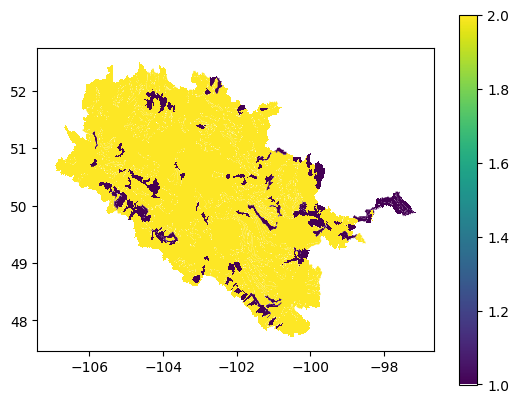

In [11]:
# Call the flag_ncaalg_from_files function
result_gdf = flag_ncaalg_from_files(input_basin_path, nctr_test, threshold=0.1, output_path=output_river_path)

# Display the results
print(result_gdf.head())
result_gdf.plot(column='ncontr', legend=True)


___